## Introduction
This notebook aims to create a graphical representation of lambda values vs the variance of data explained for the Ridge regression and the Lasso regression models.  We are using credit card default data in order to predict the income of the subject.  Features in this data include whether subject has defaulted, if they are a student or not, and the average balance of their credit card after they make their monthly payment.

## Import and clean the data

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn import preprocessing
%matplotlib inline
sns.set_style('white')

In [2]:
df = pd.read_csv(
    'https://vincentarelbundock.github.io/Rdatasets/csv/ISLR/Default.csv'
).iloc[:,1:].dropna()

In [3]:
df.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


Convert the strings to numeric in order for sklearn processing later.

In [4]:
# Recode strings to numeric.
df['default'] = np.where(df['default']=='Yes', 1, 0)
df['student'] = np.where(df['student']=='Yes', 1, 0)
names = df.columns
df = pd.DataFrame(preprocessing.scale(df), columns=names)

c:\users\fred\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by the scale function.
  """


In [5]:
df.head()

,default,student,balance,income
0,-0.185599,-0.645936,-0.218835,0.813187
1,-0.185599,1.548141,-0.037616,-1.605496
2,-0.185599,-0.645936,0.492410,-0.131212
3,-0.185599,-0.645936,-0.632893,0.164031
4,-0.185599,-0.645936,-0.102791,0.370915


Cut the data in half; 1st half for training, 2nd half for testing.

In [6]:
# Define the training and test sizes.
trainsize = int(df.shape[0] / 2)
df_test = df.iloc[trainsize:, :].copy()
df_train = df.iloc[:trainsize, :].copy()

In [7]:
print(trainsize)

5000


In [8]:
df_test.tail()

,default,student,balance,income
9995,-0.185599,-0.645936,-0.255990,1.460366
9996,-0.185599,-0.645936,-0.160044,-1.039014
9997,-0.185599,-0.645936,0.020751,1.883565
9998,-0.185599,-0.645936,1.516742,0.236363
9999,-0.185599,1.548141,-1.311691,-1.248805


In [9]:
df_train.tail()

,default,student,balance,income
4995,-0.185599,-0.645936,0.843672,0.574980
4996,-0.185599,-0.645936,-0.092247,0.629285
4997,-0.185599,-0.645936,2.401943,1.256498
4998,-0.185599,-0.645936,0.259541,-0.315877
4999,-0.185599,-0.645936,-0.389749,-0.350947


Set the independent and dependent (income)  variables.

In [10]:
Y_train = df_train['income'].values.reshape(-1, 1)
X_train = df_train.loc[:, ~(df_train.columns).isin(['income'])]

In [11]:
print(Y_train)

[[ 0.81318727]
 [-1.60549572]
 [-0.13121225]
 ...
 [ 1.25649771]
 [-0.31587678]
 [-0.35094738]]


In [12]:
print(X_train.head())

    default   student   balance
0 -0.185599 -0.645936 -0.218835
1 -0.185599  1.548141 -0.037616
2 -0.185599 -0.645936  0.492410
3 -0.185599 -0.645936 -0.632893
4 -0.185599 -0.645936 -0.102791


Add some knew features to test the models with correlated data.

In [13]:
# Make some new features to capture potential quadratic and cubic
# relationships between solar radiation and day or temperature.
df_train['balance_student'] = df_train['balance'] * df_train['student']
df_train['balance_default'] = df_train['balance'] * df_train['default']
df_train['student_default'] = df_train['student'] * df_train['default']
df_train['balance_sqrt'] = (df_train['balance'] + 100) ** .5
df_train['balance2'] = (df_train['balance'] + 100) ** 2
df_train['balance3'] = (df_train['balance'] + 100) ** 3

In [14]:
df_train.head()

,default,student,balance,income,balance_student,balance_default,student_default,balance_sqrt,balance2,balance3
0,-0.185599,-0.645936,-0.218835,0.813187,0.141353,0.040616,0.119885,9.989052,9956.280924,9.934493e+05
1,-0.185599,1.548141,-0.037616,-1.605496,-0.058235,0.006981,-0.287334,9.998119,9992.478229,9.988719e+05
2,-0.185599,-0.645936,0.492410,-0.131212,-0.318066,-0.091391,0.119885,10.024590,10098.724506,1.014845e+06
3,-0.185599,-0.645936,-0.632893,0.164031,0.408808,0.117464,0.119885,9.968305,9873.822052,9.811331e+05
4,-0.185599,-0.645936,-0.102791,0.370915,0.066396,0.019078,0.119885,9.994859,9979.452390,9.969194e+05


In [15]:
# only use the columns that have data in the 'income' column
X_train2 = df_train.loc[:, ~(df_train.columns).isin(['income'])]

In [16]:
print(X_train2.head())

    default   student   balance  balance_student  balance_default  \
0 -0.185599 -0.645936 -0.218835         0.141353         0.040616   
1 -0.185599  1.548141 -0.037616        -0.058235         0.006981   
2 -0.185599 -0.645936  0.492410        -0.318066        -0.091391   
3 -0.185599 -0.645936 -0.632893         0.408808         0.117464   
4 -0.185599 -0.645936 -0.102791         0.066396         0.019078   

   student_default  balance_sqrt      balance2      balance3  
0         0.119885      9.989052   9956.280924  9.934493e+05  
1        -0.287334      9.998119   9992.478229  9.988719e+05  
2         0.119885     10.024590  10098.724506  1.014845e+06  
3         0.119885      9.968305   9873.822052  9.811331e+05  
4         0.119885      9.994859   9979.452390  9.969194e+05  


In [17]:
# Test the more complex model with larger coefficients.
df_test['balance_student'] = df_test['balance'] * df_test['student']
df_test['balance_default'] = df_test['balance'] * df_test['default']
df_test['student_default'] = df_test['student'] * df_test['default']
df_test['balance_sqrt'] = (df_test['balance'] + 100) ** .5
df_test['balance2'] = (df_test['balance'] + 100) ** 2
df_test['balance3'] = (df_test['balance'] + 100) ** 3
X_test2 = df_test.loc[:, ~(df_test.columns).isin(['income'])]


In [18]:
print(X_test2.head())

       default   student   balance  balance_student  balance_default  \
5000 -0.185599  1.548141 -1.132387        -1.753095         0.210170   
5001 -0.185599 -0.645936 -0.423224         0.273376         0.078550   
5002 -0.185599 -0.645936 -0.464913         0.300304         0.086287   
5003 -0.185599 -0.645936  0.803932        -0.519289        -0.149209   
5004 -0.185599 -0.645936 -1.051294         0.679069         0.195119   

      student_default  balance_sqrt      balance2      balance3  
5000        -0.287334      9.943219   9774.804809  9.664116e+05  
5001         0.119885      9.978816   9915.534321  9.873569e+05  
5002         0.119885      9.976727   9907.233594  9.861174e+05  
5003         0.119885     10.040116  10161.432714  1.024312e+06  
5004         0.119885      9.947296   9790.846429  9.687916e+05  


## Building the model
First we build the Ridge regression model and then the Lasso model in order to compare the two graphs of varying lambdas vs variance of the data explained.

In [19]:
# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced. Note that by convention, the
# intercept is not regularized. Since we standardized the data
# earlier, the intercept should be equal to zero and can be dropped.

ridgeregr = linear_model.Ridge(alpha=10, fit_intercept=False) 
ridgeregr.fit(X_train, Y_train)
print(ridgeregr.score(X_train, Y_train))
origparams = ridgeregr.coef_[0]
print(origparams)

ridgeregrBig = linear_model.Ridge(alpha=10, fit_intercept=False)
ridgeregrBig.fit(X_train2, Y_train)
print(ridgeregrBig.score(X_train2, Y_train))
newparams = ridgeregrBig.coef_[0, 0:len(origparams)]

print('\nParameter Estimates for the same predictors for the small model'
      'and large model:')
compare = np.column_stack((origparams, newparams))
prettycompare = np.array2string(
    compare,
    formatter={'float_kind':'{0:.3f}'.format})
print(prettycompare)

0.5738739164402877
[ 1.36988466e-02 -7.57859433e-01 -3.25298557e-04]
0.5739464289613285

Parameter Estimates for the same predictors for the small modeland large model:
[[0.014 -0.002]
 [-0.758 -0.757]
 [-0.000 0.048]]


Print the r-squared valuee for the test data.

In [20]:
Y_test = df_test['income'].values.reshape(-1, 1)
print(ridgeregrBig.score(X_test2, Y_test))

0.5631804323931104


Make the graph for Ridge regression with lambdas ranging from **1 to 50 by increments of 3**.

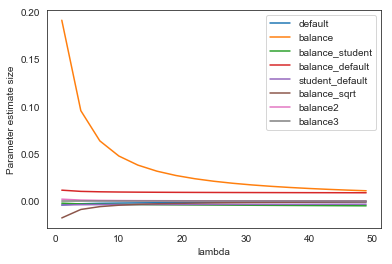

In [21]:
# Store estimates.
estimates = np.append(ridgeregrBig.coef_, [10])

# Storing legend information.
labels = []

#Run the model for many alphas.
for lambd in range(1, 50, 3):
    ridgeregrBig = linear_model.Ridge(alpha=lambd, fit_intercept=False)
    ridgeregrBig.fit(X_train2, Y_train)
    estimates = np.row_stack((
        estimates,
        np.append(ridgeregrBig.coef_,[lambd])))

# Make the data pretty.
estimates_df = pd.DataFrame(
    estimates,
    columns=list(X_train2.columns) + ['lambda'])
estimates_df.sort_values(by='lambda', inplace=True, ascending=True)

# Leave out the 'student' variable.
# It has very high values and throws off our plot's scale.
varstoplot = list(estimates_df.columns[:9,])
varstoplot.remove('student')

# Plot a line for each parameter.
for var in varstoplot:
    plt.plot(estimates_df['lambda'], estimates_df[var])
    labels.append(var)
plt.xlabel('lambda')
plt.ylabel('Parameter estimate size')
plt.legend(labels)
plt.show()

As you can see in the graph above, the 'balance', 'balance_default' and maybe 'balance_sqrt' are the relevant features (the other features are very close to zero).  You can also see that the first two features do not approach zero; they converge to a point slightly above zero.  This is different than Lass regression which we will see later where the coefficients converge to zero.

For Lasso regresion:  Use the same data and same process, except for using sklearn's Lasso regression model instead of Ridge.  

Set up the data again.

In [22]:
# Load the data again. Keep air quality data, drop the index column
# and any missing data columns.
df = pd.read_csv(
    'https://vincentarelbundock.github.io/Rdatasets/csv/ISLR/Default.csv'
).iloc[:,1:].dropna()

# Recode strings to numeric.
df['default'] = np.where(df['default']=='Yes', 1, 0)
df['student'] = np.where(df['student']=='Yes', 1, 0)
names = df.columns
df = pd.DataFrame(preprocessing.scale(df), columns=names)

# Define the training and test sizes.
trainsize = int(df.shape[0] / 2)
df_test = df.iloc[trainsize:, :].copy()
df_train = df.iloc[:trainsize, :].copy()

Y_train = df_train['income'].values.reshape(-1, 1)
X_train = df_train.loc[:, ~(df_train.columns).isin(['income'])]

# Make some new features to capture potential quadratic and cubic
# relationships between solar radiation and day or temperature.
df_train['balance_student'] = df_train['balance'] * df_train['student']
df_train['balance_default'] = df_train['balance'] * df_train['default']
df_train['student_default'] = df_train['student'] * df_train['default']
df_train['balance_sqrt'] = (df_train['balance'] + 100) ** .5
df_train['balance2'] = (df_train['balance'] + 100) ** 2
df_train['balance3'] = (df_train['balance'] + 100) ** 3

X_train2 = df_train.loc[:, ~(df_train.columns).isin(['income'])]

# Test the simpler model with smaller coefficients.
Y_test = df_test['income'].values.reshape(-1, 1)
X_test = df_test.loc[:, ~(df_test.columns).isin(['income'])]

# Test the more complex model with larger coefficients.
df_test['balance_student'] = df_test['balance'] * df_test['student']
df_test['balance_default'] = df_test['balance'] * df_test['default']
df_test['student_default'] = df_test['student'] * df_test['default']
df_test['balance_sqrt'] = (df_test['balance'] + 100) ** .5
df_test['balance2'] = (df_test['balance'] + 100) ** 2
df_test['balance3'] = (df_test['balance'] + 100) ** 3
X_test2 = df_test.loc[:, ~(df_test.columns).isin(['income'])]


c:\users\fred\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by the scale function.
  # This is added back by InteractiveShellApp.init_path()


Define the Lasso model with a lambda (set by user) of 0.35 and print the r-squared and parameter estimates.

In [23]:
# Large number of parameters.
lassBig = linear_model.Lasso(alpha=.35)
lassBig.fit(X_train2, Y_train)
print('\nR² for the model with many features:')
print(lassBig.score(X_train2, Y_train))
origparams = np.append(lassBig.coef_, lassBig.intercept_)
print('\nParameter estimates for the model with many features:')
print(origparams)


R² for the model with many features:
0.44363376712897057

Parameter estimates for the model with many features:
[ 0.00000000e+00 -3.89351238e-01  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -2.77688887e-04
 -7.09158792e-07  3.48711577e+00]


Mak a graph again (just like in the Ridge model) showing the range of lambda values vs. variance with the Lasso regression model.  Here, we have chosen lambda values between **1 and 50 increasing by 2 units** at each pass.

c:\users\fred\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\fred\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\fred\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\fred\appdata\local\programs\python\python37-32\lib\site-packa

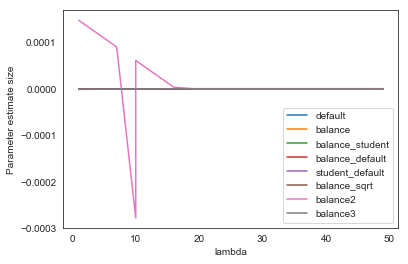

In [24]:
# Store estimates.
estimates = np.append(lassBig.coef_, [10])

# Storing legend information.
labels = []

#Run the model for many alphas.
for lambd in range(1, 50, 3):
    lassBig = linear_model.Lasso(alpha=lambd, fit_intercept=False)
    lassBig.fit(X_train2, Y_train)
    estimates = np.row_stack((
        estimates,
        np.append(lassBig.coef_,[lambd])))

# Make the data pretty.
estimates_df = pd.DataFrame(
    estimates,
    columns=list(X_train2.columns) + ['lambda'])
estimates_df.sort_values(by='lambda', inplace=True, ascending=True)

# Leave out the 'student' variable.
# It has very high values and throws off our plot's scale.
varstoplot = list(estimates_df.columns[:9,])
varstoplot.remove('student')

# Plot a line for each parameter.
for var in varstoplot:
    plt.plot(estimates_df['lambda'], estimates_df[var])
    labels.append(var)
plt.xlabel('lambda')
plt.ylabel('Parameter estimate size')
plt.legend(labels)
plt.show()

## Conclusion and discussion

As you can see in the graph above, the only relevent feature using Lasso regression is 'balance2' and it convergest to zero with a lambda of around 17.  All of the other features have converged to zero from the very beginning thus are irrevelant in this model.  It's interesting to see the coefficient is positive for most of the range except for lambda values around 10 where they turn negative.